# Chapter 9 - Hierarchical Models

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from IPython.display import Image
from matplotlib import gridspec

In [7]:
plt.style.use('seaborn-v0_8-white')
color = '#87ceeb'

In [9]:
%load_ext watermark
%watermark -p arviz,matplotlib,numpy,pandas,pymc,seaborn

arviz     : 0.20.0
matplotlib: 3.10.0
numpy     : 1.26.4
pandas    : 2.2.3
pymc      : 5.16.1
seaborn   : 0.13.2



## 9.2.3 - Example: Multiple Coins form a Single Mint

In [10]:
# Data from coin #1

n_heads1 = 3
n_tails1 = 12

n_flips1 = n_heads1 + n_tails1

data1 = np.repeat([1,0], [n_heads1, n_tails1])

data1

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
# Data from coin #2

n_heads2 = 4
n_tails2 = 1

n_flips2 = n_heads2 + n_tails2

data2 = np.repeat([1, 0], [n_heads2, n_tails2])

data2

array([1, 1, 1, 1, 0])

In [18]:
# Pack all outcomes in a single vector

outcomes = np.hstack((data1, data2))

outcomes

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0])

In [17]:
# Create a vector of coins ID
coin = np.hstack((np.zeros_like(data1), np.ones_like(data2)))

coin

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [19]:
# Build model

with pm.Model() as oneminttwocoins_model:
    # Priors
    omega = pm.Beta('omega', 2.0, 2.0)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.5, 0.5)

    # Equation to Kappa
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)

    # Equation to Theta
    theta = pm.Beta(
        'theta',
        alpha = omega * (kappa - 2) + 1,
        beta = (1 - omega) * (kappa - 2) + 1,
        shape = 2
    )

    # Likelyhood
    y = pm.Bernoulli('y', theta[coin], observed = outcomes)
    

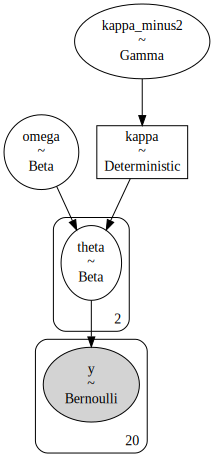

In [20]:
pm.model_to_graphviz(oneminttwocoins_model)

In [21]:
with oneminttwocoins_model:
    idata_1m2c = pm.sample(5000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, theta]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 28 seconds.


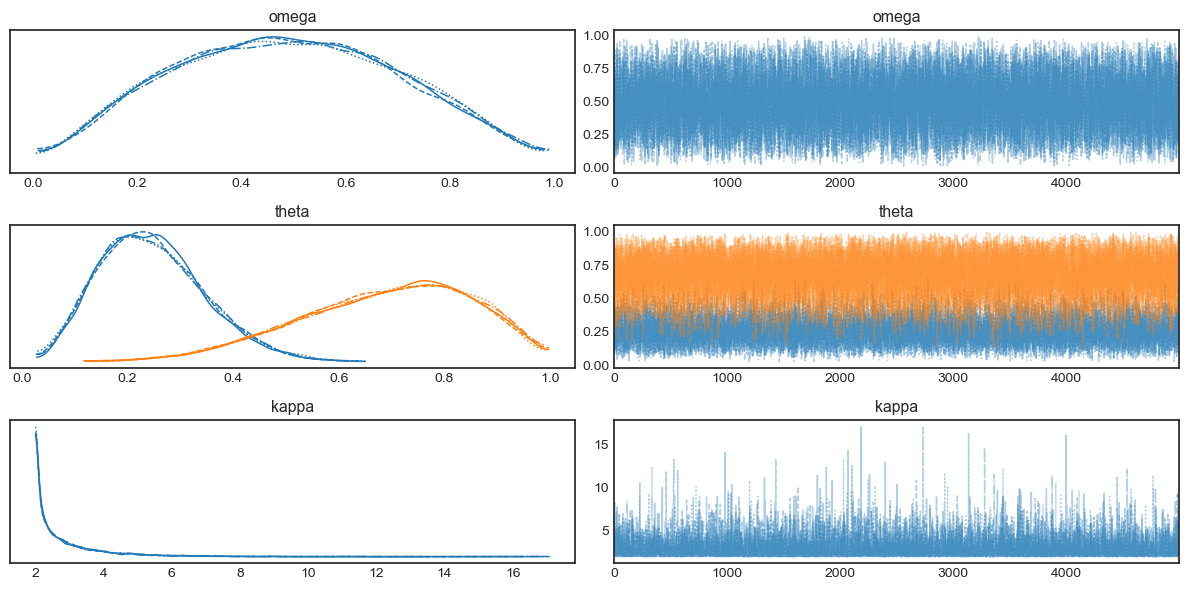

In [22]:
az.plot_trace(idata_1m2c, var_names = ['~kappa_minus2'])
plt.tight_layout();

In [23]:
az.summary(idata_1m2c)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
omega         0.488  0.216   0.100    0.872      0.002    0.001   15019.0   
kappa_minus2  0.884  1.224   0.000    3.037      0.011    0.008    8524.0   
theta[0]      0.246  0.099   0.069    0.430      0.001    0.001   14002.0   
theta[1]      0.690  0.161   0.403    0.968      0.002    0.001   10197.0   
kappa         2.884  1.224   2.000    5.037      0.011    0.008    8524.0   

              ess_tail  r_hat  
omega          11653.0    1.0  
kappa_minus2    6461.0    1.0  
theta[0]       11923.0    1.0  
theta[1]        9376.0    1.0  
kappa           6461.0    1.0

In [25]:
idata_1m2c.posterior['omega'].sel(draw = 0)

<xarray.DataArray 'omega' (chain: 4)> Size: 32B
array([0.12821869, 0.78964792, 0.57505915, 0.32086021])
Coordinates:
  * chain    (chain) int32 16B 0 1 2 3
    draw     int32 4B 0

In [26]:
idata_1m2c

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [27]:
idata_1m2c.posterior['theta'].mean(dim = ['draw', 'chain'])[0]

<xarray.DataArray 'theta' ()> Size: 8B
array(0.24608716)
Coordinates:
    theta_dim_0  int32 4B 0

In [28]:
idata_1m2c.posterior['theta'].mean(dim = ['draw', 'chain'])[1]

<xarray.DataArray 'theta' ()> Size: 8B
array(0.68985639)
Coordinates:
    theta_dim_0  int32 4B 1

In [29]:
(idata_1m2c.posterior['theta']>.5).mean(dim=['draw','chain'])[0]

<xarray.DataArray 'theta' ()> Size: 8B
array(0.01225)
Coordinates:
    theta_dim_0  int32 4B 0

In [30]:
(idata_1m2c.posterior['theta']>.5).mean(dim=['draw','chain'])[1]

<xarray.DataArray 'theta' ()> Size: 8B
array(0.86475)
Coordinates:
    theta_dim_0  int32 4B 1

## 9.2.4 - Example: Therapeutic touch

In [32]:
df = pd.read_csv('C:/Users/bacos1/Documents/Python/per_python_bayes/Doing_Bayesian_Data_Analysis/data/TherapeuticTouchData.csv', 
                 dtype = {'s': 'category'}
                )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   y       280 non-null    int64   
 1   s       280 non-null    category
dtypes: category(1), int64(1)
memory usage: 2.8 KB


In [33]:
df_proportions = (df
                  .groupby('s')['y']
                  .apply(lambda x: x.sum() / len(x))
                 )

C:\Users\bacos1\AppData\Local\Temp\ipykernel_27692\1083886035.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('s')['y']


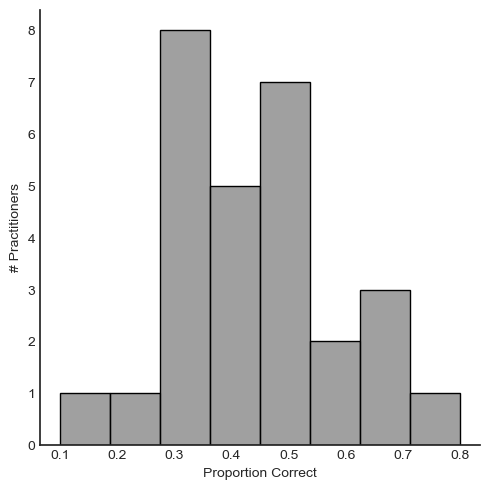

In [35]:
ax = sns.displot(
    df_proportions,
    bins = 8,
    color = 'gray'
)

ax.set(
    xlabel = 'Proportion Correct',
    ylabel = '# Practitioners'
);

In [36]:
practitioner_idx, practitioner_codes = pd.factorize(df['s'])

In [39]:
n_practitioners = df['s'].nunique()

In [41]:
with pm.Model() as therapeutictouch_model:
    #Priors
    omega = pm.Beta("omega", 1.0, 1.0)
    kappa_minus2 = pm.Gamma("kappa_minus2", 0.05, 0.05)

    # Equation to kappa
    kappa = pm.Deterministic("kappa", kappa_minus2 + 2)

    # Equation to theta
    theta = pm.Beta(
        "theta",
        alpha=omega * (kappa - 2) + 1,
        beta=(1 - omega) * (kappa - 2) + 1,
        shape=n_practitioners,
    )

    # Likelyhood
    y = pm.Bernoulli("y", theta[practitioner_idx], observed=df["y"])

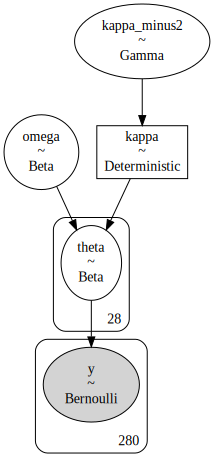

In [42]:
pm.model_to_graphviz(therapeutictouch_model)

In [43]:
with therapeutictouch_model:
    idata_tt = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, theta]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 32 seconds.


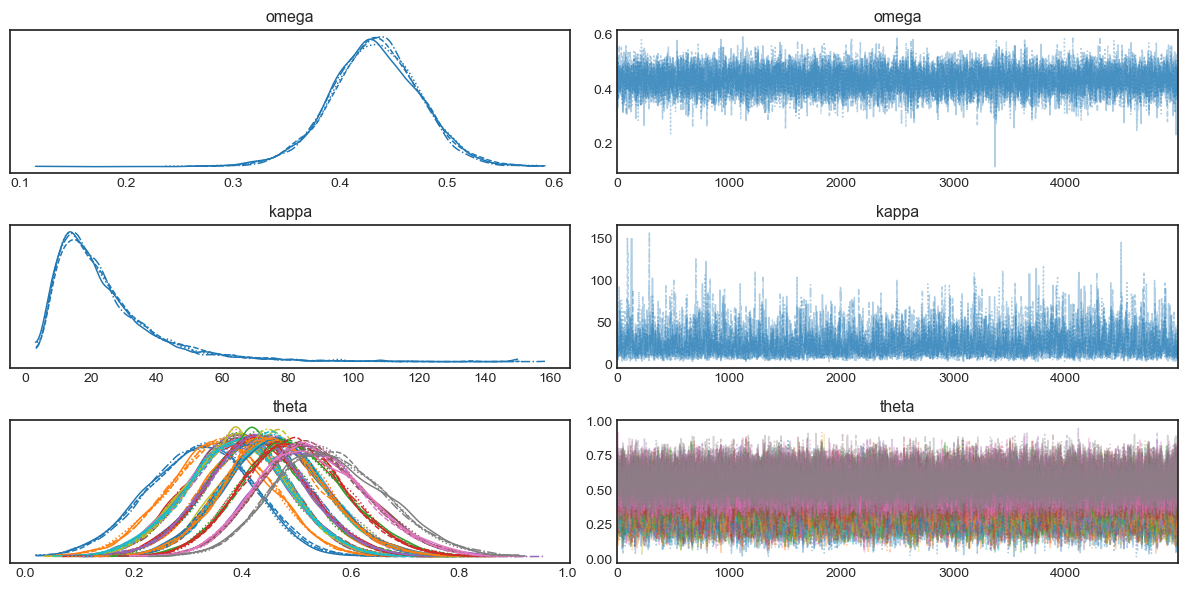

In [44]:
az.plot_trace(idata_tt, var_names = ['omega', 'kappa', 'theta'])
plt.tight_layout();

In [45]:
az.summary(idata_tt)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
omega          0.433   0.042   0.353    0.511      0.000    0.000    9898.0   
kappa_minus2  21.943  15.582   1.868   49.480      0.282    0.199    3099.0   
theta[0]       0.323   0.096   0.144    0.501      0.001    0.001    9619.0   
theta[1]       0.359   0.095   0.184    0.537      0.001    0.001   13777.0   
theta[2]       0.392   0.093   0.219    0.567      0.001    0.000   19061.0   
theta[3]       0.392   0.094   0.221    0.573      0.001    0.000   21819.0   
theta[4]       0.392   0.092   0.222    0.565      0.001    0.000   21043.0   
theta[5]       0.393   0.092   0.220    0.566      0.001    0.000   18437.0   
theta[6]       0.392   0.094   0.210    0.563      0.001    0.000   20067.0   
theta[7]       0.392   0.093   0.214    0.565      0.001    0.000   17995.0   
theta[8]       0.392   0.093   0.220    0.570      0.001    0.000   20140.0   
theta[9]       0.392   0.094   0.217    0.573      0.001    0.000   19100.0   
theta[10]      0.427   0.093   0.246    0.595      0.001    0.000   25460.0   
theta[11]      0.426   0.092   0.255    0.604      0.001    0.000   23762.0   
theta[12]      0.427   0.093   0.250    0.603      0.001    0.000   22179.0   
theta[13]      0.427   0.093   0.256    0.610      0.001    0.000   23173.0   
theta[14]      0.427   0.094   0.250    0.603      0.001    0.000   24975.0   
theta[15]      0.462   0.094   0.293    0.650      0.001    0.000   24153.0   
theta[16]      0.462   0.093   0.281    0.631      0.001    0.000   24436.0   
theta[17]      0.461   0.095   0.278    0.636      0.001    0.000   22761.0   
theta[18]      0.461   0.093   0.291    0.642      0.001    0.000   22668.0   
theta[19]      0.462   0.092   0.292    0.640      0.001    0.000   23209.0   
theta[20]      0.461   0.093   0.280    0.631      0.001    0.000   26032.0   
theta[21]      0.461   0.094   0.289    0.639      0.001    0.000   20844.0   
theta[22]      0.495   0.097   0.317    0.680      0.001    0.001   19213.0   
theta[23]      0.496   0.095   0.319    0.674      0.001    0.000   19898.0   
theta[24]      0.530   0.099   0.355    0.724      0.001    0.001   15047.0   
theta[25]      0.530   0.099   0.354    0.723      0.001    0.001   14825.0   
theta[26]      0.529   0.099   0.347    0.717      0.001    0.001   15877.0   
theta[27]      0.564   0.103   0.371    0.754      0.001    0.001   10639.0   
kappa         23.943  15.582   3.868   51.480      0.282    0.199    3099.0   

              ess_tail  r_hat  
omega          12321.0    1.0  
kappa_minus2    5310.0    1.0  
theta[0]       12042.0    1.0  
theta[1]       11819.0    1.0  
theta[2]       12430.0    1.0  
theta[3]       13852.0    1.0  
theta[4]       13231.0    1.0  
theta[5]       11754.0    1.0  
theta[6]       11852.0    1.0  
theta[7]       12438.0    1.0  
theta[8]       13575.0    1.0  
theta[9]       12516.0    1.0  
theta[10]      14440.0    1.0  
theta[11]      13128.0    1.0  
theta[12]      13589.0    1.0  
theta[13]      13727.0    1.0  
theta[14]      13825.0    1.0  
theta[15]      12977.0    1.0  
theta[16]      13753.0    1.0  
theta[17]      13990.0    1.0  
theta[18]      14141.0    1.0  
theta[19]      13702.0    1.0  
theta[20]      14409.0    1.0  
theta[21]      11920.0    1.0  
theta[22]      12688.0    1.0  
theta[23]      13753.0    1.0  
theta[24]      12268.0    1.0  
theta[25]      12572.0    1.0  
theta[26]      12894.0    1.0  
theta[27]      12415.0    1.0  
kappa           5310.0    1.0

In [46]:
(idata_tt
 .posterior['theta']
 .mean(dim = ['chain', 'draw'])
 .sel(theta_dim_0 = 0)
)

<xarray.DataArray 'theta' ()> Size: 8B
array(0.32340697)
Coordinates:
    theta_dim_0  int32 4B 0

<>:28: SyntaxWarning: invalid escape sequence '\{'
<>:28: SyntaxWarning: invalid escape sequence '\{'
C:\Users\bacos1\AppData\Local\Temp\ipykernel_27692\1264413070.py:28: SyntaxWarning: invalid escape sequence '\{'
  ax.set_xlabel("$\{}$".format(var), fontdict={"size": 20, "weight": "bold"})


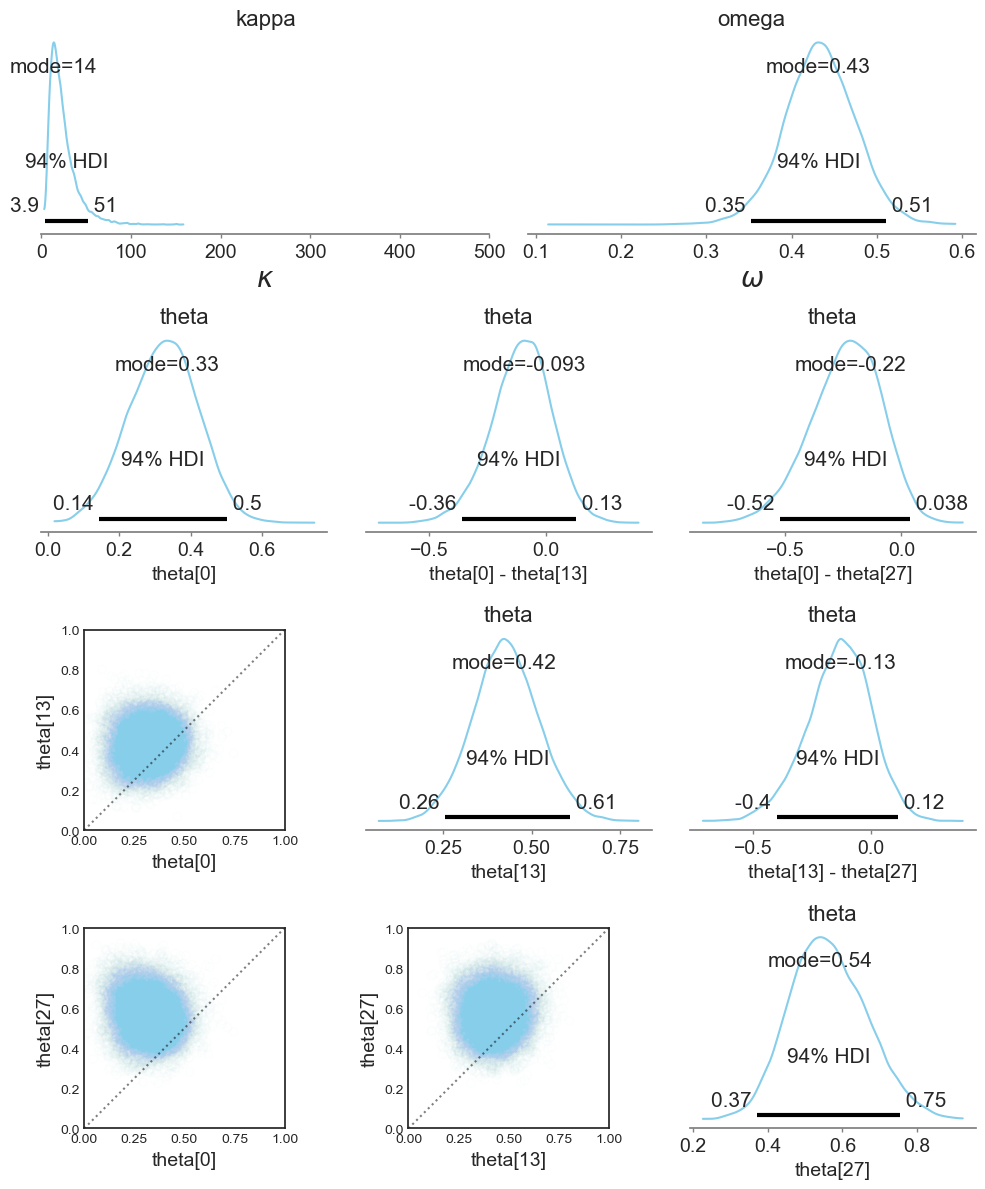

In [47]:
plt.figure(figsize=(10, 12))

# Define gridspec
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0, :3])
ax2 = plt.subplot(gs[0, 3:])
ax3 = plt.subplot(gs[1, :2])
ax4 = plt.subplot(gs[1, 2:4])
ax5 = plt.subplot(gs[1, 4:6])
ax6 = plt.subplot(gs[2, :2])
ax7 = plt.subplot(gs[2, 2:4])
ax8 = plt.subplot(gs[2, 4:6])
ax9 = plt.subplot(gs[3, :2])
ax10 = plt.subplot(gs[3, 2:4])
ax11 = plt.subplot(gs[3, 4:6])

# thetas and theta pairs to plot
thetas = (0, 13, 27)
theta_pairs = ((0, 13), (0, 27), (13, 27))

font_d = {"size": 14}

# kappa & omega posterior plots
for var, ax in zip(["kappa", "omega"], [ax1, ax2]):
    az.plot_posterior(
        idata_tt.posterior[var], point_estimate="mode", ax=ax, color=color, round_to=2
    )
    ax.set_xlabel("$\{}$".format(var), fontdict={"size": 20, "weight": "bold"})
ax1.set(xlim=(0, 500))

# theta posterior plots
for var, ax in zip(thetas, [ax3, ax7, ax11]):
    az.plot_posterior(
        idata_tt.posterior["theta"].sel(theta_dim_0=var),
        point_estimate="mode",
        ax=ax,
        color=color,
    )
    ax.set_xlabel("theta[{}]".format(var), fontdict=font_d)

# theta scatter plots
for var, ax in zip(theta_pairs, [ax6, ax9, ax10]):
    ax.scatter(
        idata_tt.posterior["theta"].sel(theta_dim_0=var[0]),
        idata_tt.posterior["theta"].sel(theta_dim_0=var[1]),
        alpha=0.02,
        color=color,
        facecolor="none",
    )
    ax.plot([0, 1], [0, 1], ":k", transform=ax.transAxes, alpha=0.5)
    ax.set_xlabel("theta[{}]".format(var[0]), fontdict=font_d)
    ax.set_ylabel("theta[{}]".format(var[1]), fontdict=font_d)
    ax.set(xlim=(0, 1), ylim=(0, 1), aspect="equal")

# theta posterior differences plots
for var, ax in zip(theta_pairs, [ax4, ax5, ax8]):
    az.plot_posterior(
        idata_tt.posterior["theta"].sel(theta_dim_0=var[0])
        - idata_tt.posterior["theta"].sel(theta_dim_0=var[1]),
        point_estimate="mode",
        ax=ax,
        color=color,
    )
    ax.set_xlabel("theta[{}] - theta[{}]".format(*var), fontdict=font_d)

plt.tight_layout()

## 9.5.1 - Example: Baseball batting abilities by position

In [48]:
df2 = pd.read_csv(
    'C:/Users/bacos1/Documents/Python/per_python_bayes/Doing_Bayesian_Data_Analysis/data/BattingAverage.csv',
    usecols = [0, 1, 2, 3],
    dtype = {'PriPos':'category'}
)

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Player  948 non-null    object  
 1   PriPos  948 non-null    category
 2   Hits    948 non-null    int64   
 3   AtBats  948 non-null    int64   
dtypes: category(1), int64(2), object(1)
memory usage: 23.6+ KB


In [49]:
df2['BatAv'] = df2.Hits.divide(df2.AtBats)

In [50]:
df2.head(10)

Player      PriPos  Hits  AtBats     BatAv
0   Fernando Abad     Pitcher     1       7  0.142857
1     Bobby Abreu  Left Field    53     219  0.242009
2      Tony Abreu    2nd Base    18      70  0.257143
3   Dustin Ackley    2nd Base   137     607  0.225700
4      Matt Adams    1st Base    21      86  0.244186
5   Nathan Adcock     Pitcher     0       1  0.000000
6  Jeremy Affeldt     Pitcher     0       1  0.000000
7   Brandon Allen    1st Base     2      20  0.100000
8   Yonder Alonso    1st Base   150     549  0.273224
9     Jose Altuve    2nd Base   167     576  0.289931

In [52]:
(df2
 .groupby('PriPos', observed = False)[['Hits', 'AtBats']]
 .sum()
 .pipe(
     lambda x: x.Hits / x.AtBats
 )    
)

PriPos
1st Base        0.258851
2nd Base        0.255676
3rd Base        0.265036
Catcher         0.247404
Center Field    0.263513
Left Field      0.259077
Pitcher         0.129148
Right Field     0.263555
Shortstop       0.255186
dtype: float64

In [53]:
pripos_idx, pripos_codes = pd.factorize(df2["PriPos"])

In [54]:
n_pripos = df2["PriPos"].nunique()
n_players = df2["Player"].nunique()

In [56]:
with pm.Model() as hierarchical_model2:
    # Priros for hyper parameters
    omega = pm.Beta('omega', 1, 1)
    kappa_minus2 = pm.Gamma("kappa_minus2", 0.1, 0.1)
    kappa = pm.Deterministic("kappa", kappa_minus2 + 2)

    # Priors for categories (PriPos)
    omega_c = pm.Beta(
        'omega_c',
        omega * (kappa - 2) + 1,
        (1 - omega) * (kappa - 2) + 1,
        shape=n_pripos,
    )

    kappa_c_minus2 = pm.Gamma("kappa_c_minus2", 0.01, 0.01, shape=n_pripos)
    kappa_c = pm.Deterministic("kappa_c", kappa_c_minus2 + 2)

    # Priors for individual players
    theta = pm.Beta(
        'theta',
        omega_c[pripos_idx] * (kappa_c[pripos_idx] - 2) +1,
        (1 - omega_c[pripos_idx]) * (kappa_c[pripos_idx] - 2) + 1,
        shape = n_players
    )

    # Likelyhood

    y2 = pm.Binomial(
        'y2',
        n = df2.AtBats.values,
        p = theta,
        observed = df2['Hits']
    )

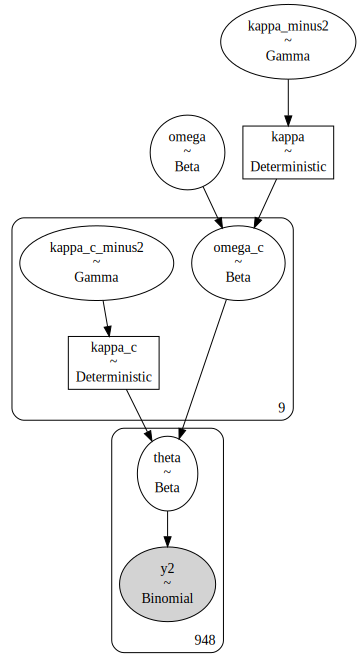

In [57]:
pm.model_to_graphviz(hierarchical_model2)

In [58]:
with hierarchical_model2:
    idata2 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, omega_c, kappa_c_minus2, theta]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 94 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


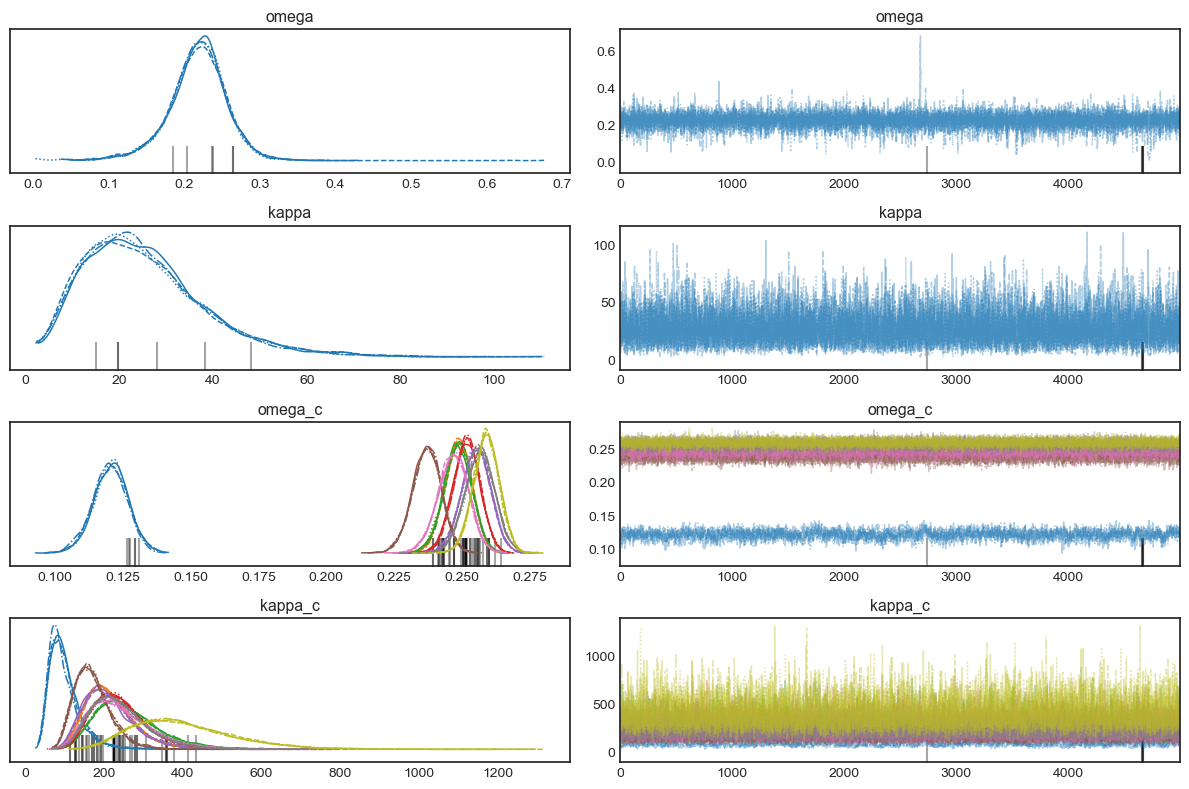

In [59]:
az.plot_trace(
    idata2,
    var_names = ['omega', 'kappa', 'omega_c', 'kappa_c']
)

plt.tight_layout()

Text(0.5, 0, 'omega')

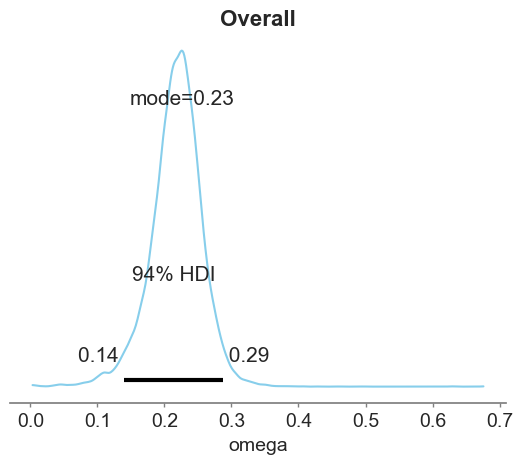

In [60]:
az.plot_posterior(
    idata2.posterior['omega'],
    point_estimate = 'mode',
    color = color
)

plt.title(
    'Overall',
    fontdict={"fontsize": 16, "fontweight": "bold"}
)

plt.xlabel(
    'omega',
    fontdict={"fontsize": 14}
)

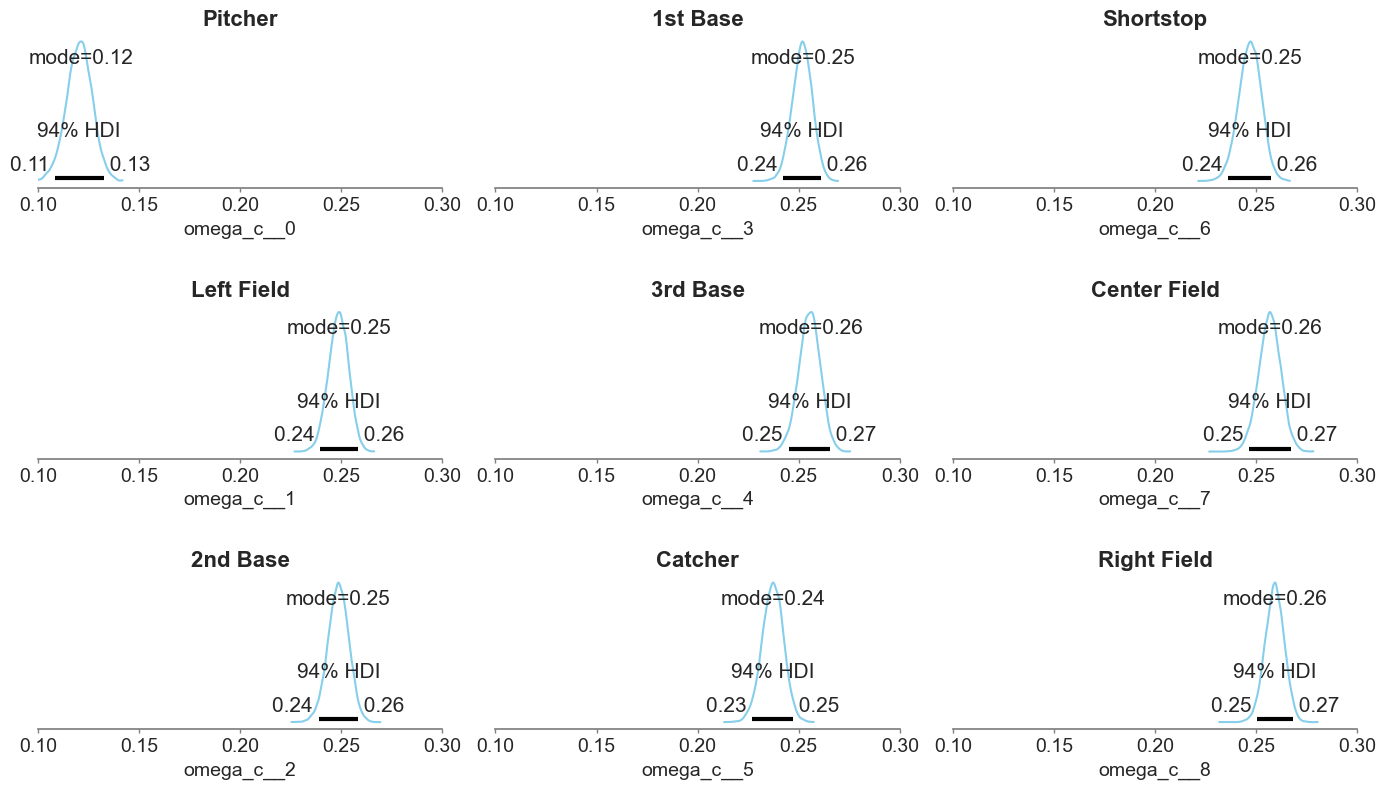

In [61]:
fig, axes = plt.subplots(3, 3, figsize=(14, 8))

for i, ax in enumerate(axes.T.flatten()):
    az.plot_posterior(
        idata2.posterior["omega_c"].sel(omega_c_dim_0=i),
        ax=ax,
        point_estimate="mode",
        color=color,
    )
    ax.set_title(pripos_codes[i], fontdict={"fontsize": 16, "fontweight": "bold"})
    ax.set_xlabel("omega_c__{}".format(i), fontdict={"fontsize": 14})
    ax.set_xlim(0.10, 0.30)

plt.tight_layout(h_pad=3);